<a href="https://colab.research.google.com/github/gaurisharma360/steganography/blob/main/wbstenograph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 147 kB 26.5 MB/s 
     |████████████████████████████████| 181 kB 64.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=02b45cc82a993495e70b57f59e1f2d1d4faccddbac34cd3fea695af24b53a7e2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-07-20 12:33:56--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  55.5MB/s    in 5.2s    

2022-07-20 12:34:01 (45.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [6]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [7]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)


In [8]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [9]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [10]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

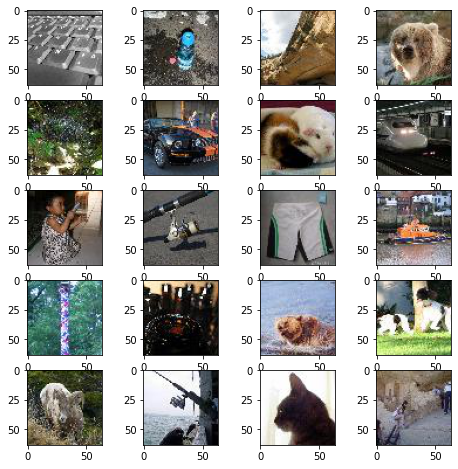

In [11]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [12]:
import wandb
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='selu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='selu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return importKerasNetwork(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder
 

In [13]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 300:
        return 0.0003

In [14]:
import wandb
wandb.init(project='stenography')
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'rev_loss',
      'goal': 'minimize'   
    },
    'parameters': {

        'lr':{
            'values':[0.001]
        },
        'activation':{
            'values':['relu']
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: btq4vinh
Sweep URL: https://wandb.ai/gaurisharama360/uncategorized/sweeps/btq4vinh


In [15]:
def train(e,lr):
    
  wandb.init(project='stenography_tf',name='selu'+str(lr)+str(e))
  print(wandb.config)
  NB_EPOCHS = e
  BATCH_SIZE = 32
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  K.set_value(autoencoder_model.optimizer.lr,lr)
  K.set_value(reveal_model.optimizer.lr,lr)
  m = input_S.shape[0]
  loss_history = []
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)

      ae_loss = []
      rev_loss = []
      cover_imgs=[]
      secret_imgs=[]
      encoded_secrets=[]
      decoded_secrets=[]
      diff_ss=[]
      diff_cc=[]
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          
          C_prime = encoder_model.predict([batch_S, batch_C])
          aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                    y=np.concatenate((batch_S, batch_C),axis=3))
          
          ae_loss.append(aeLoss)

          revLoss = reveal_model.train_on_batch(x=C_prime,
                                                y=batch_S)
          rev_loss.append(revLoss)
          wandb.log({"ae_loss":aeLoss})

          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      
      mean_ae_loss = np.mean(ae_loss)
      wandb.log({"mean_ae_loss":mean_ae_loss})

      loss_history.append(mean_ae_loss)
      print(len(loss_history))
      if (epoch+1)%40==0:
        # Retrieve decoded predictions.
        decoded = autoencoder_model.predict([input_S, input_C])
        decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

        # Get absolute difference between the outputs and the expected values.
        diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

        # Configs for results display

        # Show images in gray scale
        SHOW_GRAY = False
        # Show difference bettwen predictions and ground truth.
        SHOW_DIFF = True

        # Diff enhance magnitude
        ENHANCE = 1

        # Number of secret and cover pairs to show.
        n = 6

        def rgb2gray(rgb):
            return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

        def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
            ax = plt.subplot(n_rows, n_col, idx)
            if gray:
                plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
            else:
                plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if first_row:
                plt.title(title)

        fig = plt.figure(figsize=(14, 15))
        rand_indx = [random.randint(0, 999) for x in range(n)]
        # for i, idx in enumerate(range(0, n)):
        for i, idx in enumerate(rand_indx):
            n_col = 6 if SHOW_DIFF else 4
            cover = input_C[idx]
            show_image(cover, n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
            cover_imgs.append(cover)
            #wandb.log({"Cover":wandb.Image(input_C[idx])})

            secret = input_S[idx]
            show_image(secret, n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
            secret_imgs.append(secret)
            #wandb.log({"Secret":wandb.Image(input_S[idx])})
            
            encoded_secret = decoded_C[idx]
            show_image(encoded_secret, n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
            encoded_secrets.append(encoded_secret)
            #wandb.log({"Encoded Secret":wandb.Image(decoded_C[idx])})
            
            decoded_secret = decoded_S[idx]
            show_image(decoded_secret, n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
            decoded_secrets.append(decoded_secret)
            #wandb.log({"Decoded Cover":wandb.Image(decoded_S[idx])})
            
            
            if SHOW_DIFF:
                diff_c = np.multiply(diff_C[idx], ENHANCE)
                show_image(diff_c, n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
                diff_cc.append(diff_c)
                #wandb.log({"Diff Cover":wandb.Image(diff_C[idx])})
                
                diff_s = np.multiply(diff_S[idx], ENHANCE)
                show_image(diff_s, n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')
                diff_ss.append(diff_s)
                #wandb.log({"Diff Secret":wandb.Image(diff_S[idx])})

        # Now we can save it to a numpy array.
        plt.savefig('output.png')

        plt.show()
        wandb.log({"Output":wandb.Image('output.png')})
        


        




       
  plt.plot(loss_history)

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()



{}


Epoch 1 | Batch: 992 of 1000. Loss AE 7669806.63 | Loss Rev 5007328.24: 100%|██████████| 32/32 [00:31<00:00,  1.00it/s]


1


Epoch 2 | Batch: 992 of 1000. Loss AE 4409318.07 | Loss Rev 1863720.79: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


2


Epoch 3 | Batch: 992 of 1000. Loss AE 3663379.84 | Loss Rev 1684759.15: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


3


Epoch 4 | Batch: 992 of 1000. Loss AE 3766493.26 | Loss Rev 1869749.03: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


4


Epoch 5 | Batch: 992 of 1000. Loss AE 3472084.67 | Loss Rev 1574993.17: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


5


Epoch 6 | Batch: 992 of 1000. Loss AE 2600219.86 | Loss Rev  703876.42: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


6


Epoch 7 | Batch: 992 of 1000. Loss AE 2563788.58 | Loss Rev  668137.53: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


7


Epoch 8 | Batch: 992 of 1000. Loss AE 2546640.54 | Loss Rev  653968.00: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


8


Epoch 9 | Batch: 992 of 1000. Loss AE 2703525.09 | Loss Rev  823003.99: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


9


Epoch 10 | Batch: 992 of 1000. Loss AE 2569179.00 | Loss Rev  692595.51: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


10


Epoch 11 | Batch: 992 of 1000. Loss AE 2545727.11 | Loss Rev  671661.77: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


11


Epoch 12 | Batch: 992 of 1000. Loss AE 2540958.07 | Loss Rev  670282.53: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


12


Epoch 13 | Batch: 992 of 1000. Loss AE 2533543.50 | Loss Rev  670339.62: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


13


Epoch 14 | Batch: 992 of 1000. Loss AE 2440769.31 | Loss Rev  783514.59: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


14


Epoch 15 | Batch: 992 of 1000. Loss AE 2575234.66 | Loss Rev  699054.74: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


15


Epoch 16 | Batch: 992 of 1000. Loss AE 3415705.29 | Loss Rev 1426747.22: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


16


Epoch 17 | Batch: 992 of 1000. Loss AE 2626405.96 | Loss Rev  730528.12: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


17


Epoch 18 | Batch: 992 of 1000. Loss AE 2540233.31 | Loss Rev  627940.56: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


18


Epoch 19 | Batch: 992 of 1000. Loss AE 2029592.06 | Loss Rev  129932.95: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


19


Epoch 20 | Batch: 992 of 1000. Loss AE 1944101.96 | Loss Rev   45302.36: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


20


Epoch 21 | Batch: 992 of 1000. Loss AE 1937832.58 | Loss Rev   39032.87: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


21


Epoch 22 | Batch: 992 of 1000. Loss AE 1936293.12 | Loss Rev   37492.91: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


22


Epoch 23 | Batch: 992 of 1000. Loss AE 1933267.92 | Loss Rev   34467.08: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


23


Epoch 24 | Batch: 992 of 1000. Loss AE 1930647.08 | Loss Rev   31847.41: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


24


Epoch 25 | Batch: 992 of 1000. Loss AE 1928936.76 | Loss Rev   30136.57: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


25


Epoch 26 | Batch: 992 of 1000. Loss AE 1928963.62 | Loss Rev   30163.14: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


26


Epoch 27 | Batch: 992 of 1000. Loss AE 1929337.26 | Loss Rev   30537.38: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


27


Epoch 28 | Batch: 992 of 1000. Loss AE 1928394.83 | Loss Rev   29594.90: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


28


Epoch 29 | Batch: 992 of 1000. Loss AE 1928470.31 | Loss Rev   29670.31: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


29


Epoch 30 | Batch: 992 of 1000. Loss AE 1928571.44 | Loss Rev   29770.72: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


30


Epoch 31 | Batch: 992 of 1000. Loss AE 1928948.46 | Loss Rev   30148.07: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


31


Epoch 32 | Batch: 992 of 1000. Loss AE 1929642.24 | Loss Rev   30842.44: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


32


Epoch 33 | Batch: 992 of 1000. Loss AE 1929323.68 | Loss Rev   30523.61: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


33


Epoch 34 | Batch: 992 of 1000. Loss AE 1928396.94 | Loss Rev   29596.39: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


34


Epoch 35 | Batch: 992 of 1000. Loss AE 1928881.30 | Loss Rev   30080.59: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


35


Epoch 36 | Batch: 992 of 1000. Loss AE 1928922.41 | Loss Rev   30122.22: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


36


Epoch 37 | Batch: 992 of 1000. Loss AE 1929749.51 | Loss Rev   30949.00: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


37


Epoch 38 | Batch: 992 of 1000. Loss AE 1928803.06 | Loss Rev   30003.00: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


38


Epoch 39 | Batch: 992 of 1000. Loss AE 1929156.96 | Loss Rev   30358.14: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


39


Epoch 40 | Batch: 992 of 1000. Loss AE 1928850.75 | Loss Rev   30050.12: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

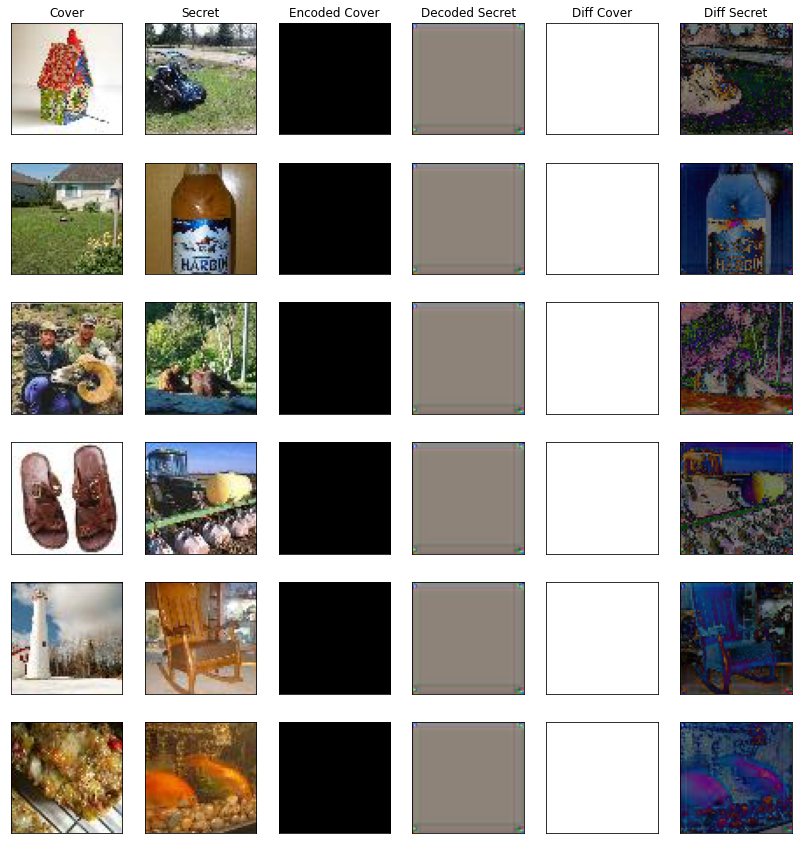

Epoch 41 | Batch: 992 of 1000. Loss AE 1930215.70 | Loss Rev   31415.45: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


41


Epoch 42 | Batch: 992 of 1000. Loss AE 1929417.92 | Loss Rev   30618.19: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


42


Epoch 43 | Batch: 992 of 1000. Loss AE 1928670.28 | Loss Rev   29870.50: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


43


Epoch 44 | Batch: 992 of 1000. Loss AE 1929052.49 | Loss Rev   30251.71: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


44


Epoch 45 | Batch: 992 of 1000. Loss AE 1928804.02 | Loss Rev   30003.90: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


45


Epoch 46 | Batch: 992 of 1000. Loss AE 1928766.33 | Loss Rev   29966.44: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


46


Epoch 47 | Batch: 992 of 1000. Loss AE 1928717.66 | Loss Rev   29917.04: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


47


Epoch 48 | Batch: 992 of 1000. Loss AE 1929035.74 | Loss Rev   30235.36: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


48


Epoch 49 | Batch: 992 of 1000. Loss AE 1929539.83 | Loss Rev   30739.74: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


49


Epoch 50 | Batch: 992 of 1000. Loss AE 1929426.93 | Loss Rev   30627.18: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


50


Epoch 51 | Batch: 992 of 1000. Loss AE 1929811.50 | Loss Rev   31011.67: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


51


Epoch 52 | Batch: 992 of 1000. Loss AE 1929891.35 | Loss Rev   31091.22: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


52


Epoch 53 | Batch: 992 of 1000. Loss AE 1930351.34 | Loss Rev   31551.28: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


53


Epoch 54 | Batch: 992 of 1000. Loss AE 1929465.78 | Loss Rev   30665.78: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


54


Epoch 55 | Batch: 992 of 1000. Loss AE 1928600.09 | Loss Rev   29799.75: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


55


Epoch 56 | Batch: 992 of 1000. Loss AE 1929319.23 | Loss Rev   30518.75: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]


56


Epoch 57 | Batch: 992 of 1000. Loss AE 1929923.57 | Loss Rev   31123.45: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


57


Epoch 58 | Batch: 992 of 1000. Loss AE 1928795.10 | Loss Rev   29995.30: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


58


Epoch 59 | Batch: 992 of 1000. Loss AE 1928405.77 | Loss Rev   29606.05: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


59


Epoch 60 | Batch: 992 of 1000. Loss AE 1928863.25 | Loss Rev   30063.09: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


60


Epoch 61 | Batch: 992 of 1000. Loss AE 1928564.94 | Loss Rev   29764.96: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


61


Epoch 62 | Batch: 992 of 1000. Loss AE 1928974.50 | Loss Rev   30174.68: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


62


Epoch 63 | Batch: 992 of 1000. Loss AE 1928268.87 | Loss Rev   29468.73: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


63


Epoch 64 | Batch: 992 of 1000. Loss AE 1928561.23 | Loss Rev   29761.01: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


64


Epoch 65 | Batch: 992 of 1000. Loss AE 1928405.83 | Loss Rev   29606.14: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


65


Epoch 66 | Batch: 992 of 1000. Loss AE 1928142.12 | Loss Rev   29342.06: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


66


Epoch 67 | Batch: 992 of 1000. Loss AE 1928610.53 | Loss Rev   29810.12: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


67


Epoch 68 | Batch: 992 of 1000. Loss AE 1929687.71 | Loss Rev   30887.75: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


68


Epoch 69 | Batch: 992 of 1000. Loss AE 1929082.51 | Loss Rev   30282.73: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


69


Epoch 70 | Batch: 992 of 1000. Loss AE 1928676.68 | Loss Rev   29876.39: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


70


Epoch 71 | Batch: 992 of 1000. Loss AE 1928712.68 | Loss Rev   29912.26: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


71


Epoch 72 | Batch: 992 of 1000. Loss AE 1929177.40 | Loss Rev   30377.07: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


72


Epoch 73 | Batch: 992 of 1000. Loss AE 1929207.14 | Loss Rev   30406.88: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


73


Epoch 74 | Batch: 992 of 1000. Loss AE 1928460.93 | Loss Rev   29661.17: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


74


Epoch 75 | Batch: 992 of 1000. Loss AE 1928395.84 | Loss Rev   29595.74: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


75


Epoch 76 | Batch: 992 of 1000. Loss AE 1930301.97 | Loss Rev   31502.62: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


76


Epoch 77 | Batch: 992 of 1000. Loss AE 1930199.26 | Loss Rev   31399.18: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


77


Epoch 78 | Batch: 992 of 1000. Loss AE 1929045.17 | Loss Rev   30245.41: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


78


Epoch 79 | Batch: 992 of 1000. Loss AE 1928964.18 | Loss Rev   30164.26: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


79


Epoch 80 | Batch: 992 of 1000. Loss AE 1929149.20 | Loss Rev   30348.79: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

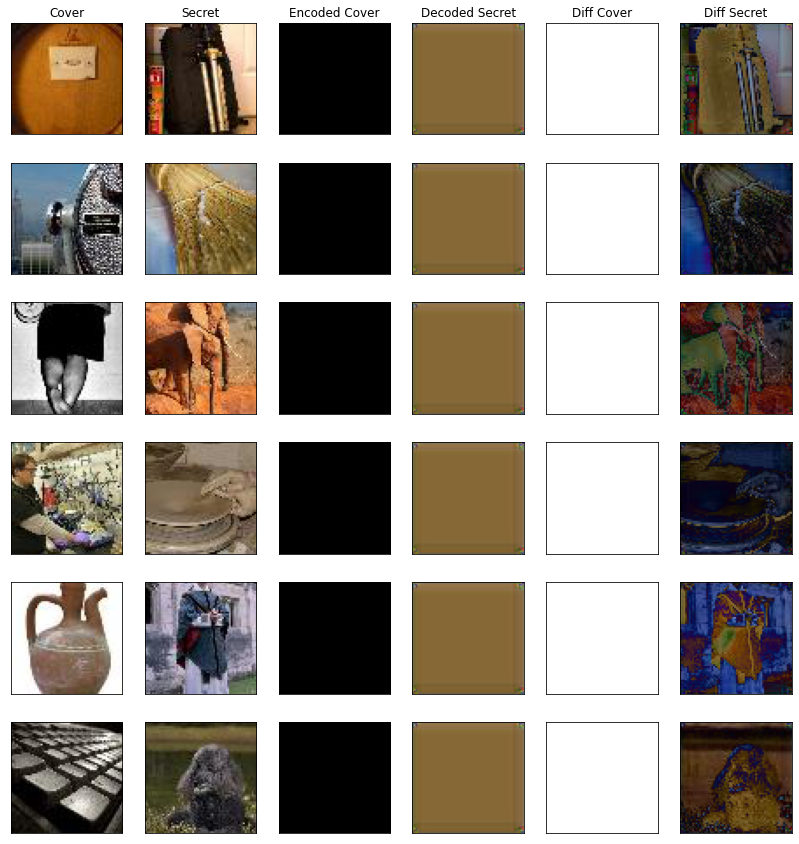

Epoch 81 | Batch: 992 of 1000. Loss AE 1929668.10 | Loss Rev   30867.91: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


81


Epoch 82 | Batch: 992 of 1000. Loss AE 1928587.51 | Loss Rev   29787.37: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


82


Epoch 83 | Batch: 992 of 1000. Loss AE 1928495.70 | Loss Rev   29695.91: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


83


Epoch 84 | Batch: 992 of 1000. Loss AE 1928664.49 | Loss Rev   29863.66: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


84


Epoch 85 | Batch: 992 of 1000. Loss AE 1928512.99 | Loss Rev   29713.03: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


85


Epoch 86 | Batch: 992 of 1000. Loss AE 1928511.27 | Loss Rev   29711.49: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


86


Epoch 87 | Batch: 992 of 1000. Loss AE 1930016.08 | Loss Rev   31215.53: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


87


Epoch 88 | Batch: 928 of 1000. Loss AE 1978403.89 | Loss Rev   31715.17:  94%|█████████▍| 30/32 [00:14<00:00,  2.02it/s]


KeyboardInterrupt: ignored

In [16]:
train(300,0.001)
train(600,0.001)
train(600,0.005)

In [ ]:
import wandb
api = wandb.Api()
run = api.run("authors/stenography_tf/2ybrkdyp")
run.config["lr"] = 0.001
run.config["epochs"] = 300
run.config['activation'] = 'tanh'
run.update()